Example notebook to have a look at the results of 'vasca_pipe -cfg ../vasca_cfg.yaml' from the examples folder.
The output of the pipline was stored in the folder vasca_pipeline.

General path setup and library loading

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

from jdaviz import Imviz
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits

region_fname = "./vasca_pipeline/TDS_COSMOS/region_TDS_COSMOS.fits"

Show basic region information

In [2]:
rg = Region()
rg.load_from_fits(region_fname)
rg.tt_fields.show_in_notebook()
#rg.info() # Show available tables

idx,field_id,name,ra,dec,observatory,obs_filter,sel,fov_diam,nr_vis,time_bin_size_sum,time_start,time_stop
,,,deg,deg,,,,deg,,s,d,d
0,GNU2604912508670050304,PS_COSMOS_MOS21,150.50213748204703,3.09702777491166,GALEX,NUV,True,1.1,29,28075.799999999996,54510.593935185185,56535.16921296297
1,GNU2604982877414227968,PS_COSMOS_MOS22,149.49989874061703,3.10005767451708,GALEX,NUV,True,1.1,29,27164.39999999999,54509.566979166666,56515.80884259259
2,GNU2605053246158405632,PS_COSMOS_MOS23,151.00379402274802,2.20171000810559,GALEX,NUV,True,1.1,29,39526.049999999996,54510.66210648148,57273.52699074074
3,GNU2605123614902583296,PS_COSMOS_MOS24,149.99874146524496,2.20495017931632,GALEX,NUV,True,1.1,27,38478.85,54509.635150462964,57280.44542824074
4,GNU2605193983646760960,PS_COSMOS_MOS25,148.998105554709,2.29798225654256,GALEX,NUV,True,1.1,28,25040.5,54509.43004629629,56592.96416666667
5,GNU2605264352416104448,PS_COSMOS_MOS26,150.499346004512,1.29936606898427,GALEX,NUV,True,1.1,31,43563.8,54509.703622685185,57288.48233796296
6,GNU2605334721135116288,PS_COSMOS_MOS27,149.499506466688,1.29867662291422,GALEX,NUV,True,1.1,31,42569.400000000016,54509.49822916667,57293.60076388889


In [3]:
rg.tt_sources[:5].show_in_notebook()

idx,fd_src_id,ra,dec,nr_det,nr_uls,mag_mean,mag_err_mean,mag_var,flux_cpval,flux_rchiq,mag_dmax,mag_dmax_sig,ul_weight,sel,field_id,rg_src_id
,,deg,deg,,,mag,mag,mag2,,,mag,,,,,
0,0,150.40457112738952,3.274494460870788,29,0,20.852947695501918,0.06969524444691066,0.011061383193179784,0.0006150492343995146,2.09241686880295,0.2073607609189807,3.2959334145059795,0.0,False,GNU2604912508670050304,0
1,1,150.5742541980467,3.3976608511102597,28,1,19.138801302228654,0.02365743282384106,0.0010061099713855478,0.0019921712082692543,1.9643209547483005,0.07243510654994267,3.59125981930482,0.0,False,GNU2604912508670050304,1
2,2,150.4736107860369,3.2402016357654566,28,1,20.330085686274938,0.049904845122780116,0.00294926007349464,0.2436465357784013,1.1738134137397436,0.12896340233939085,2.661656617648628,0.0,False,GNU2604912508670050304,2
3,3,150.438179956698,3.396365362898529,28,1,21.338409287588938,0.09477458628160614,0.01849814534187548,0.006168771595595112,1.8090761006001104,0.35333456311906986,2.5620558983990502,0.0,False,GNU2604912508670050304,3
4,4,150.3963836401688,3.3777986971254554,28,1,20.72072090421404,0.06263203320226499,0.007677970052047202,0.001675428747347213,1.9872915801969966,0.15324081693376712,2.3988186571081718,0.0,False,GNU2604912508670050304,4


Show visits informtation

Plot light curves for some selected sources and show first points of lightcurve in BinnedTimeSeries format

In [4]:
plot_lc = False
if plot_lc:
    sel = rg.tt_sources["sel"]
    rg_src_ids = rg.tt_sources[sel]["rg_src_id"][0:14]
    fig_lc = plt.figure(figsize=(10, 10))
    vvis.plot_light_curve(rg,rg_src_ids=rg_src_ids)
    plt.tight_layout()
    plt.show()
    lcs = rg.get_light_curve(rg_src_ids=rg_src_ids)
    lcs[rg_src_ids[0]][0:4].show_in_notebook()

Display the lightcurve info for some more selected sources

Look at sky of specific field

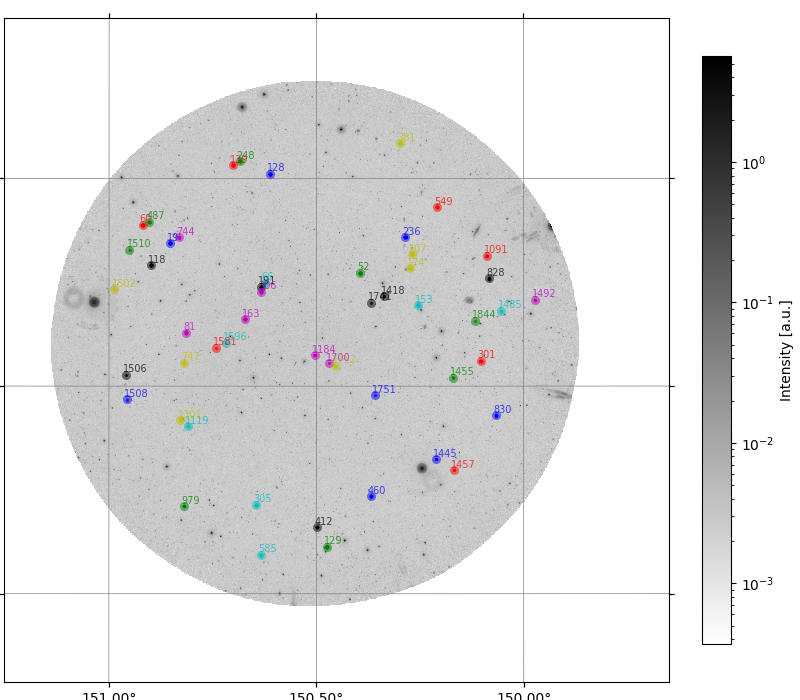

In [5]:
plot_field = True
if plot_field:
    field_id = rg.tt_fields["field_id"][0]
    fd = rg.fields[field_id]
    fig_sky = vvis.plot_field_sky(fd,plot_detections=True)

Get coverage hp map and plot in sky

<HpxGnomonicAxes: title={'center': 'Nr. of visits'}>

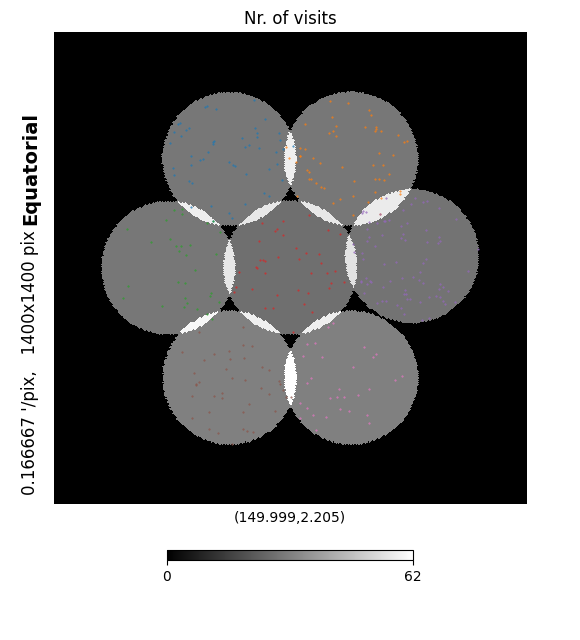

In [6]:
rg.add_coverage_hp(nside=4096)
vvis.plot_region_sky_gnomeview(rg,rg.tt_fields[3]["ra"],rg.tt_fields[3]["dec"])
#write healpix map to Aladin format, modify names
# hpy.fitsfunc.write_map(filename,[hp_vis, hp_exp],coord="C",column_names=["nr_vis", "exposure"],dtype=[np.float32, np.float32],overwrite=True,partial=True)

Plot sky image with Imviz, show source and detection markers on-top

In [7]:
show_imviz = False
if show_imviz:
    hdup = fits.PrimaryHDU(fd.ref_img, header=fd.ref_wcs.to_header())
    imviz = Imviz()
    viewer = imviz.default_viewer
    imviz.load_data(hdup, data_label=str(field_id))
    imviz.show(loc='sidecar')

    sel_det = fd.tt_detections["sel"]
    tt_det_sky = Table({'coord': SkyCoord(fd.tt_detections[sel_det]["ra"], fd.tt_detections[sel_det]["dec"], frame='fk5')})
    viewer.marker = {'color':'blue', 'markersize': 5., 'fill': False} #, 'alpha': 1.0
    viewer.add_markers(tt_det_sky, use_skycoord=True, marker_name='D')

    srcs_sky = SkyCoord(fd.tt_sources["ra"], fd.tt_sources["dec"], frame='fk5')
    tt_srcs_sky = Table({'coord':srcs_sky })
    viewer.marker = {'color':'red', 'markersize': 2., 'fill': True} #, 'alpha': 1.0
    viewer.add_markers(tt_srcs_sky, use_skycoord=True, marker_name='S')

Show field diagnostic plots

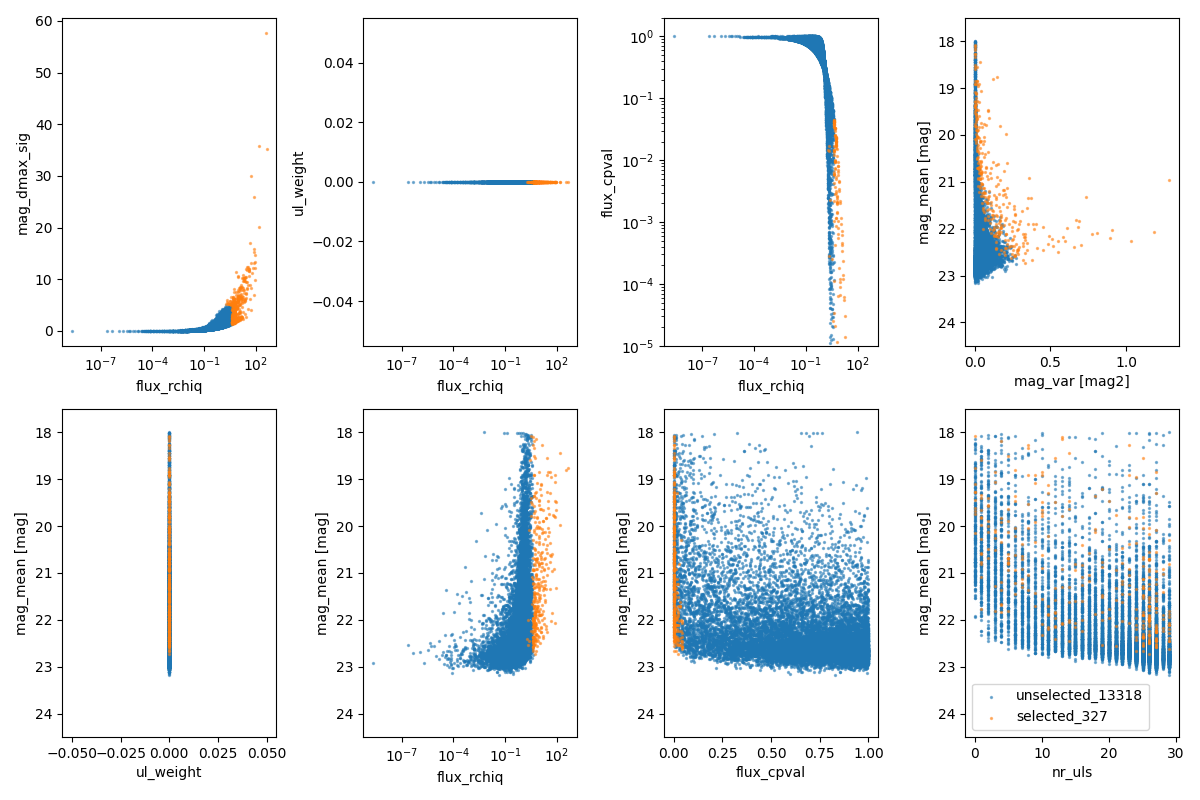

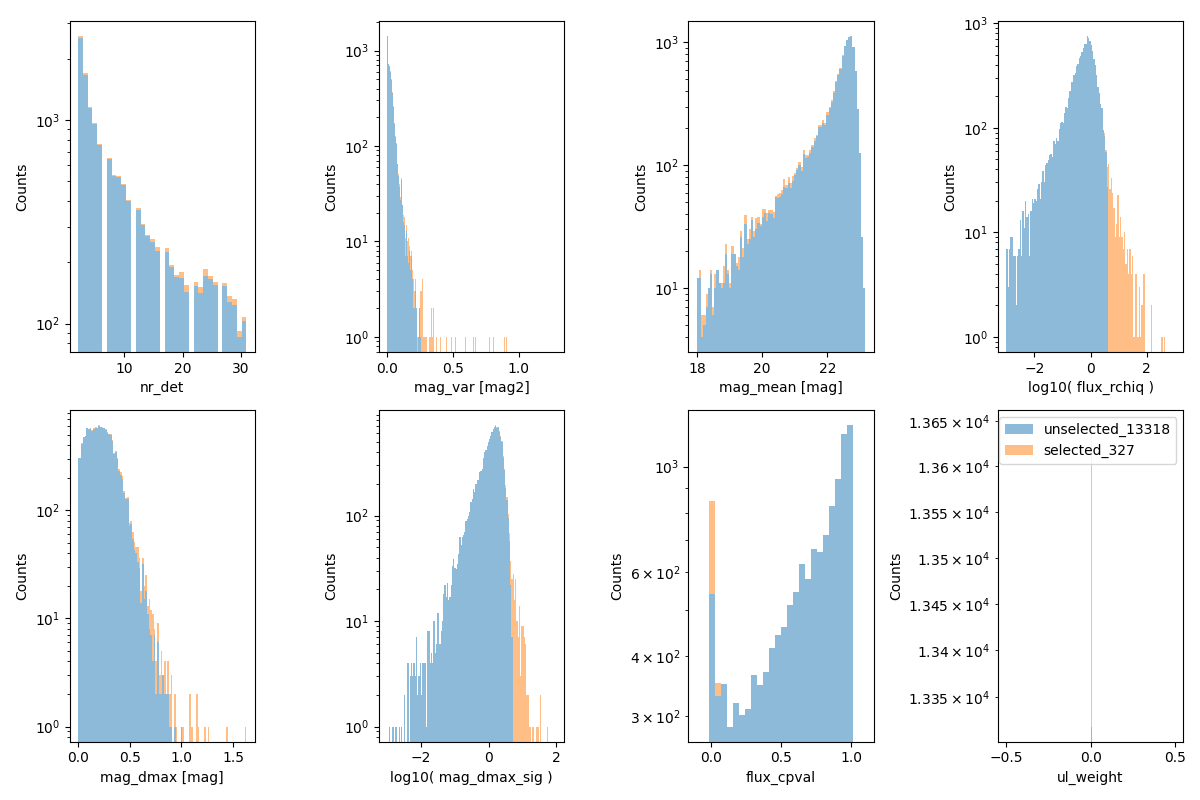

In [8]:
fig_fd_det_diag_hist = vvis.plot_pipe_diagnostic(rg, "tt_sources", "scatter")
fig_rg_src_diag_scat, plot_pars = vvis.plot_pipe_diagnostic(rg, "tt_sources", "hist")

Look into more details for the chisquare distribution

Text(0.5, 0, 'Reduced chisquare')

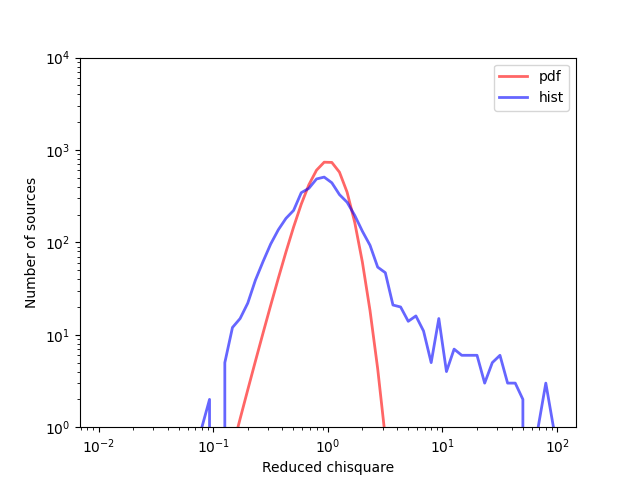

In [9]:
#Setup binning
rchisq_bins_lg = np.linspace(-2, 2, 61)
rchisq_bins = np.power(10,rchisq_bins_lg)
rchisq_bins_mean = (rchisq_bins[:-1]+rchisq_bins[1:])/2.
rchisq_bins_width = rchisq_bins[1:]-rchisq_bins[:-1]

#Select events
sel_det = rg.tt_sources["nr_det"]>10

#Calculate expected rchiq distribution for selected events
rchsq_pdf = np.zeros(len(rchisq_bins_mean))
#Get summed reduced chisquare distribution
for src in rg.tt_sources[sel_det]:
    rchsq_pdf += chi2.pdf(rchisq_bins_mean, src["nr_det"]-1, scale = 1/(src["nr_det"]-1) )*rchisq_bins_width 

rchiq_hist, bins = np.histogram(rg.tt_sources[sel_det]["flux_rchiq"], bins = rchisq_bins)

fig_rchsq = plt.figure()
plt.loglog(rchisq_bins_mean, rchsq_pdf ,'r-', lw=2, alpha=0.6, label='pdf')
plt.loglog(rchisq_bins_mean, rchiq_hist ,'b-', lw=2, alpha=0.6, label='hist')
plt.ylim(1e-0,1e4)
plt.legend()
plt.ylabel("Number of sources")
plt.xlabel("Reduced chisquare")

Look at the Pval distibutions for different magnitudes

[]

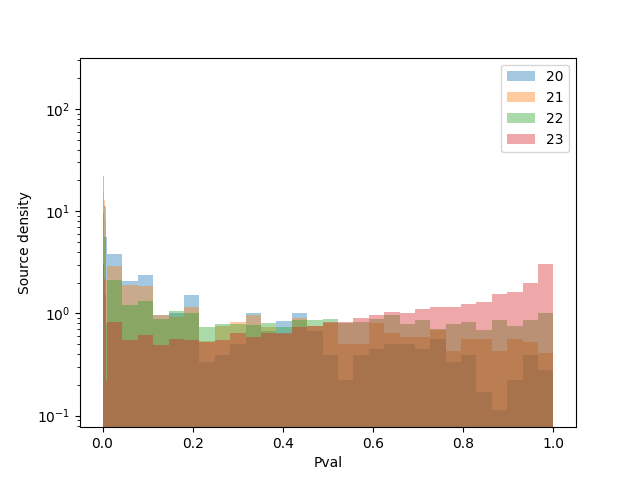

In [10]:
plot_logx = False

#Get pval data and saturate it at low Pval for better plotting
pval_min = 1e-8
pvals = rg.tt_sources["flux_cpval"]
pvals = (pvals<pval_min+1e-12)*(pval_min+1e-12)+(pvals>pval_min)*pvals

#Setup binning
bins_fine = np.linspace(1e-6, 0.01, 30)
bins_wide = np.linspace(0.01, 1.0, 30)
pval_bins = np.concatenate((bins_fine,bins_wide))

if plot_logx:
    pval_bins_lg = np.linspace(np.log10(pval_min), 0, 101)
    pval_bins = np.power(10,pval_bins_lg)
    pval_bins_mean = (pval_bins[:-1]+pval_bins[1:])/2.

#Plotting for different magnitude cuts
fig_pval = plt.figure()
for mag_cut in range(20,24):
    sel_mag = rg.tt_sources["mag_mean"]<mag_cut
    if plot_logx:
        pval_hist, bins = np.histogram(pvals[sel_mag], bins=pval_bins, density=True)
        plt.loglog(pval_bins_mean, pval_hist , lw=2, alpha=0.6, label=str(mag_cut)) 
    else:
        plt.hist(rg.tt_sources[sel_mag]["flux_cpval"], bins=pval_bins, density=True ,label=str(mag_cut),alpha=0.4)   #, ,cumulative=1

        plt.legend()
plt.xlabel("Pval")
plt.ylabel("Source density")
plt.semilogy()

Reproduce Fig. 3 from Gezari et al. ApJ 2013

idx,fd_src_id,ra,dec,nr_det,nr_uls,mag_mean,mag_err_mean,mag_var,flux_cpval,flux_rchiq,mag_dmax,mag_dmax_sig,ul_weight,sel,field_id,rg_src_id
,,deg,deg,,,mag,mag,mag2,,,mag,,,,,
0,2,150.4736107860369,3.2402016357654566,28,1,20.330085686274938,0.049904845122780116,0.00294926007349464,0.2436465357784013,1.1738134137397436,0.12896340233939085,2.661656617648628,0.0,False,GNU2604912508670050304,2
1,5,150.39104300287138,3.2846908245735214,28,1,19.597630160195486,0.03119230829179287,0.0014015107269702769,0.1445540529876186,1.2881095940324203,0.09964050565447025,2.9292517471690225,0.0,False,GNU2604912508670050304,5
2,6,150.3611669536331,2.8232568198001733,28,1,20.153667790549143,0.043202544429472516,0.0023968072141518446,0.29321432262976677,1.1287245223887263,0.13081135068620853,2.3441120415388035,0.0,False,GNU2604912508670050304,6
3,7,150.27855507137556,2.9021901221140767,28,1,21.38831056867327,0.09851208621902126,0.007913394737457448,0.8431962353947187,0.7295475783800895,0.2564896174839575,2.3175926298957936,0.0,False,GNU2604912508670050304,7
4,8,150.69065482755752,3.387989250161916,27,2,20.63069640265571,0.06107080396678713,0.005511247075329989,0.05771669165133912,1.4701672934963321,0.15602217780219263,3.0491704994557285,0.0,False,GNU2604912508670050304,8


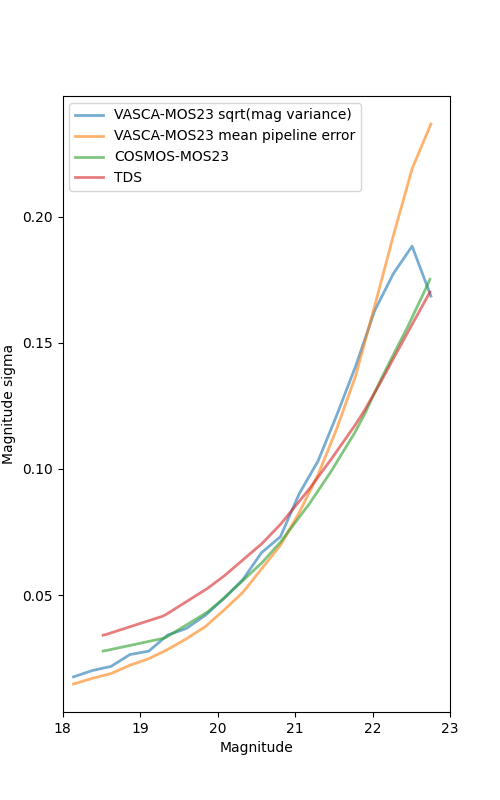

In [11]:
sel_cpval = rg.tt_sources["flux_cpval"]>0.01
sel_field = rg.tt_sources["field_id"]=="GNU2605053246158405632"
sel_ndet = rg.tt_sources["nr_det"]>10
sel_all = sel_cpval*sel_ndet #*sel_field

mag_var_hist, var_bins = np.histogram(rg.tt_sources["mag_mean"][sel_all], bins=20, density=False, weights = np.sqrt(rg.tt_sources["mag_var"][sel_all]))
mag_err_hist, var_bins = np.histogram(rg.tt_sources["mag_mean"][sel_all], bins=20, density=False, weights = rg.tt_sources["mag_err_mean"][sel_all])
mag_var_entries, bins = np.histogram(rg.tt_sources["mag_mean"][sel_all], bins=var_bins, density=False)

var_bins_mean = (var_bins[:-1]+var_bins[1:])/2.

#Get TDS Fig 3 data
tt_tds= Table.read("./TDS-ApJ_766_60/GezariApJ2013_TDS_Fig3.csv")

#Plot
fig_mag_var = plt.figure(figsize=(5, 8))
plt.plot(var_bins_mean , mag_var_hist/mag_var_entries ,lw=2, alpha=0.6, label="VASCA-MOS23 sqrt(mag variance)")
plt.plot(var_bins_mean , mag_err_hist/mag_var_entries ,lw=2, alpha=0.6, label="VASCA-MOS23 mean pipeline error")
plt.plot(tt_tds["mag"] , tt_tds["MOS23"] ,lw=2, alpha=0.6, label="COSMOS-MOS23")
plt.plot(tt_tds["mag"] , tt_tds["TDS"] ,lw=2, alpha=0.6, label="TDS")

plt.xlabel("Magnitude")
plt.ylabel("Magnitude sigma")
plt.legend()

plt.xlim([18, 23])
#plt.ylim([0.001, 0.499])

#fig_mag_var.get_axes()[0].set_yticks(np.linspace(0, 0.5, 26))
#plt.grid()
#plt.semilogy()

rg.tt_sources[sel_cpval][:5].show_in_notebook()